<a href="https://colab.research.google.com/github/Alex-SKC/paris-workshop-2025/blob/main/Detecting_and_Evaluating_Cutback_Opportunities_Using_SkillCorner_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Ce notebook montre comment utiliser les données de tracking et les **Dynamic Events** de SkillCorner pour analyser des schémas offensifs, avec un focus particulier sur les passes en retrait (*cutbacks*).

Nous allons illustrer comment :
- Détecter les **opportunités de passe en retrait**, qu’elles soient effectuées ou non,
- Agréger ces événements au **niveau joueur** afin d’évaluer des profils individuels,
- Fournir une base flexible permettant aux clubs de construire leurs **propres métriques personnalisées** si nécessaire.

Même si ce notebook utilise les passes en retrait comme étude de cas, la même approche peut être appliquée à tout type d’action ou de situation tactique, réalisée ou simplement potentielle.

C’est parti.

# Qu’est-ce qu’une passe en retrait (*cutback*) ?

Une passe en retrait est un type spécifique de passe finale, jouée depuis l’intérieur de la surface adverse, généralement depuis le demi-espace proche de la ligne de but, et dirigée au sol vers l’arrière, souvent en direction du point de penalty.

Dans ce notebook, nous définissons une passe en retrait comme :
- Une passe **démarrant depuis la zone de livraison du cutback** (zone vert clair), située dans le demi-espace et proche de la ligne de but,  
- Se terminant dans la **zone cible du cutback** (zone vert foncé), située devant le but, entre la largeur des poteaux,  
- Avec une **direction négative sur l’axe x**, c’est-à-dire jouée vers l’arrière par rapport au but attaqué.

Ces zones sont définies dans le système de coordonnées de SkillCorner et peuvent être ajustées pour correspondre à la compréhension tactique de votre équipe concernant les passes en retrait.

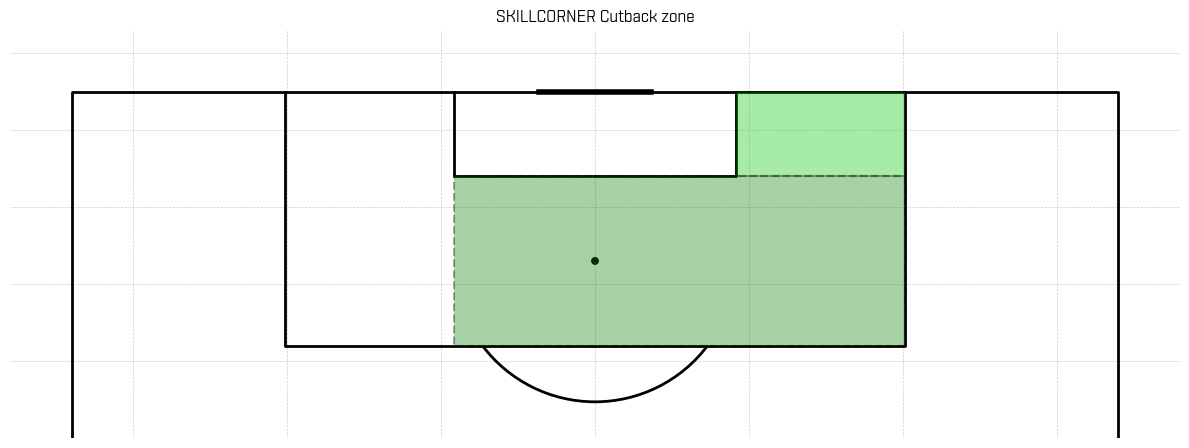

Le cercle ci-dessous illustre l’ensemble des options de passe disponibles pour le porteur du ballon, avec le cône en surbrillance représentant les angles qui qualifient une passe en retrait (*cutback*) : des passes jouées vers l’arrière depuis les zones excentrées vers les zones centrales dangereuses.

<p align="center">
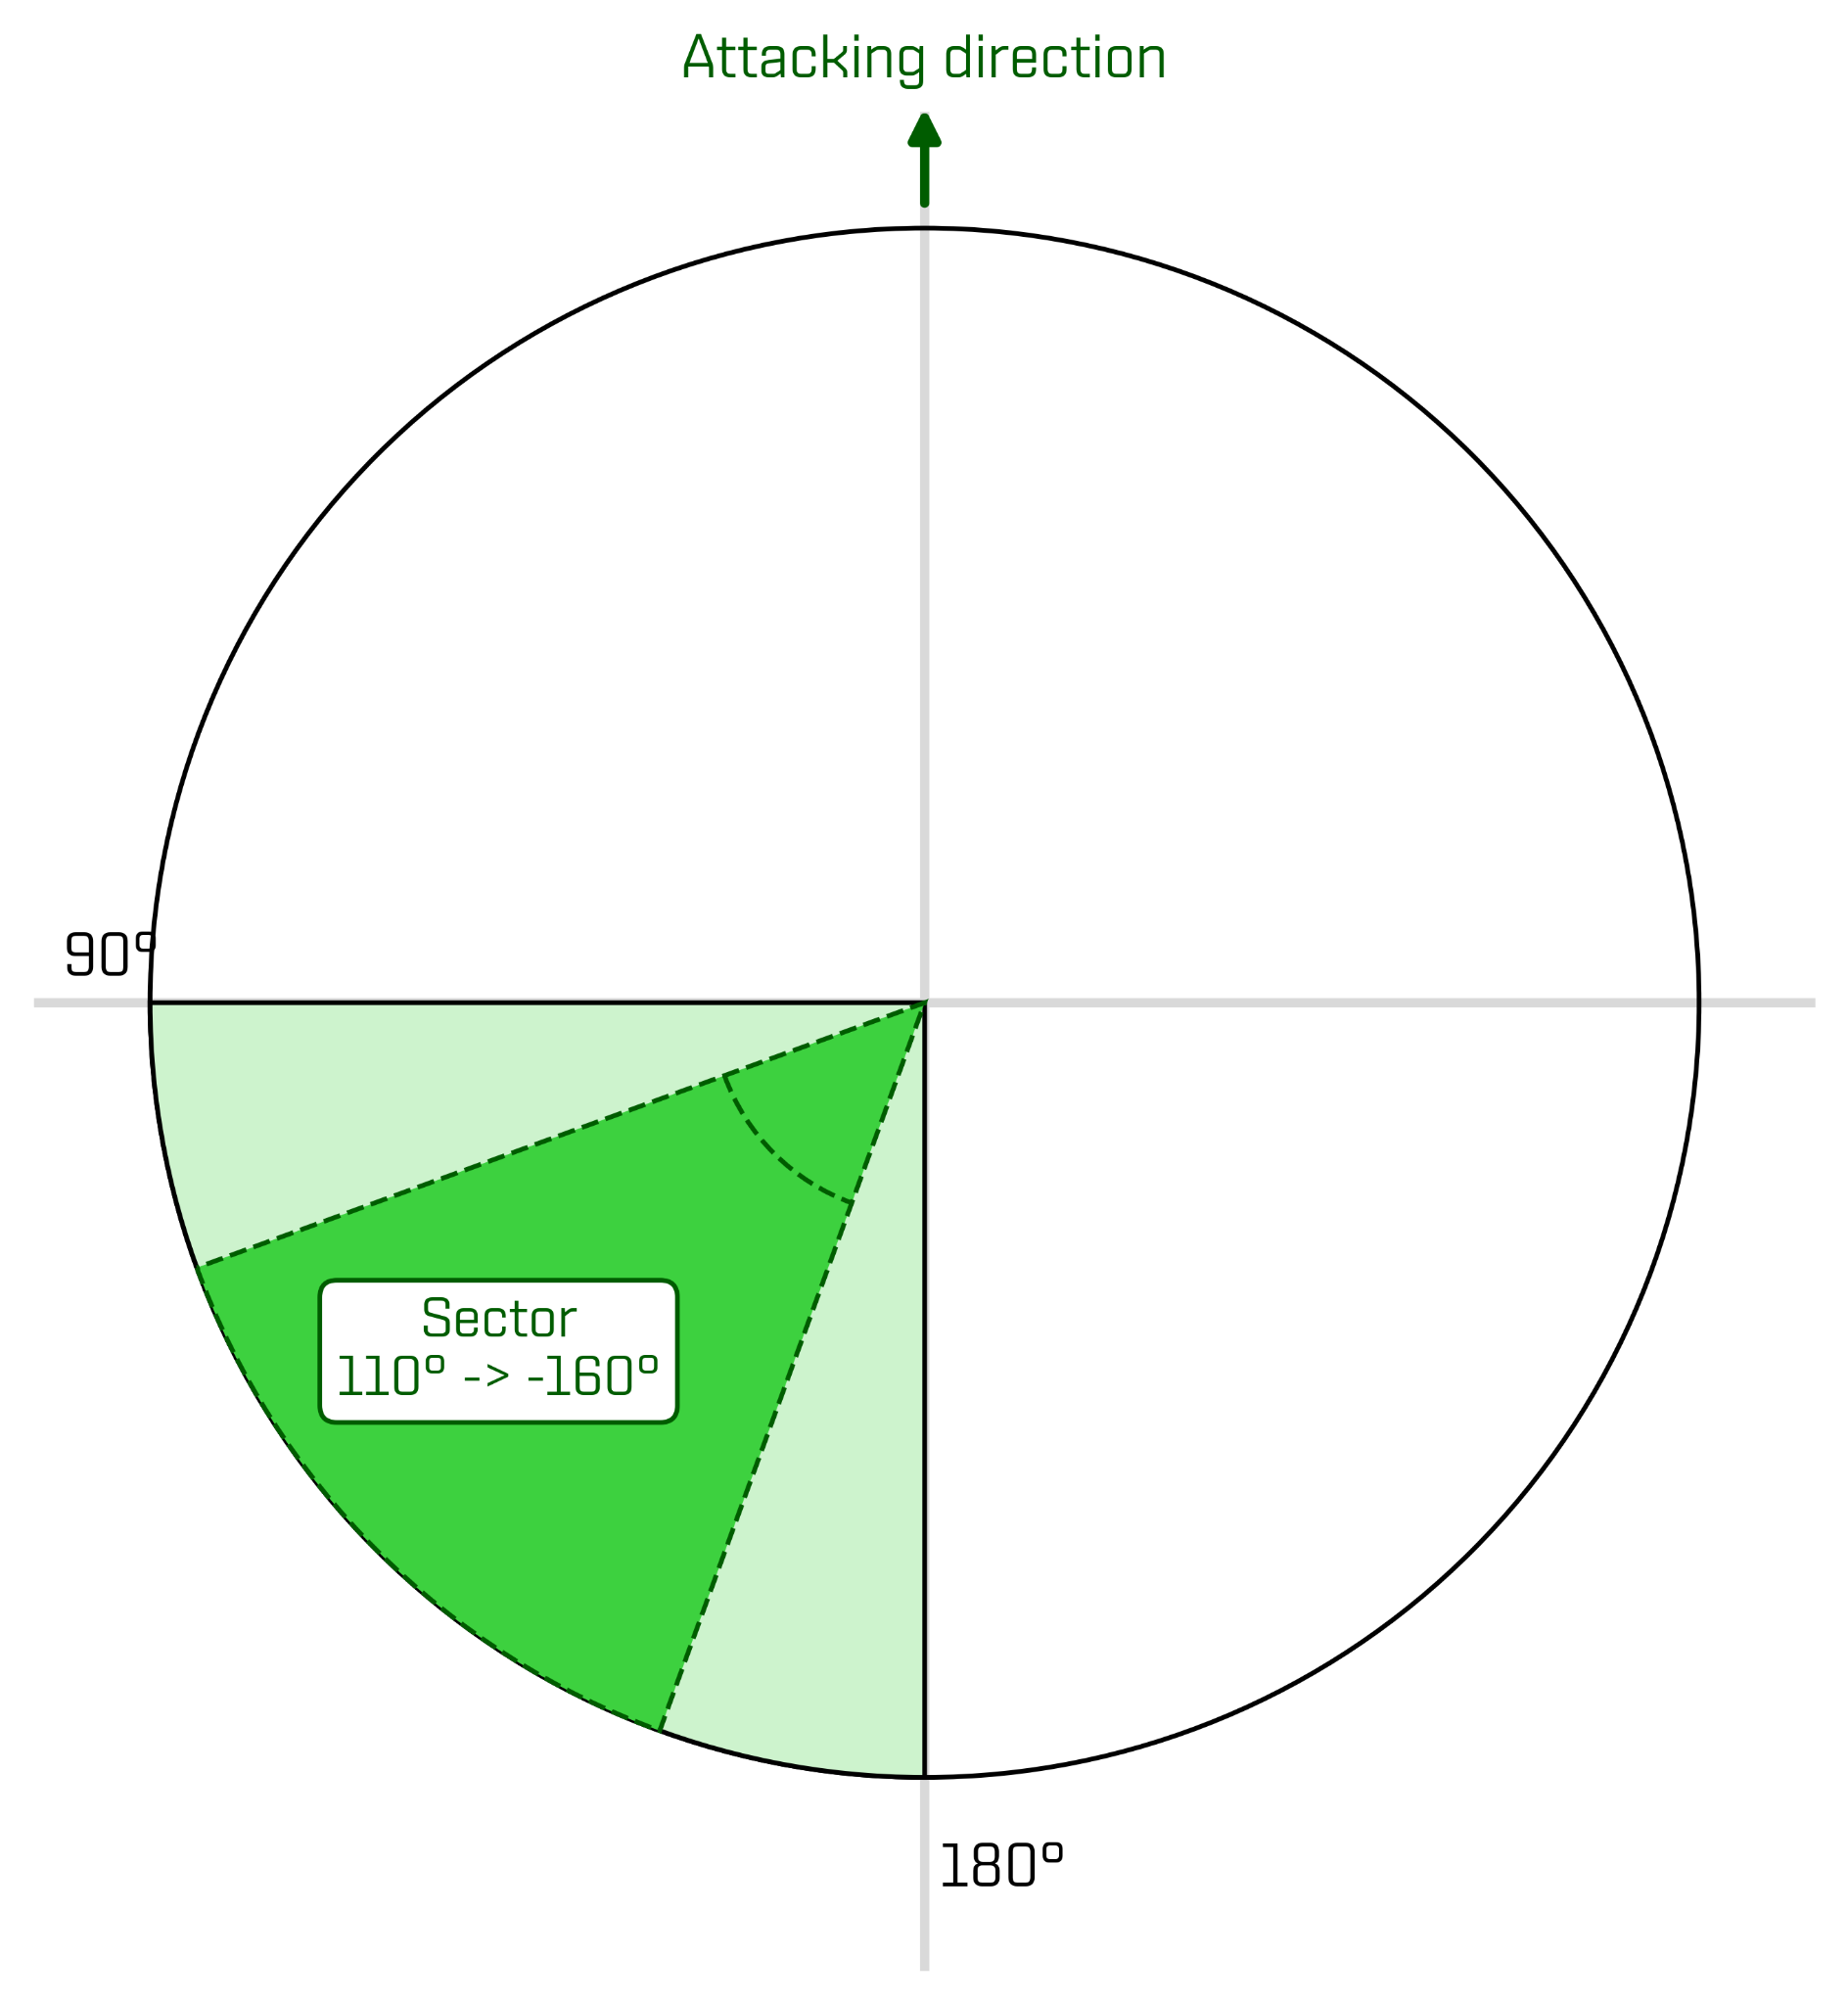
</p>

# 🔐 Imports et authentification du client

In [ ]:
# Installer le client API SkillCorner (si non déjà installé)
!pip install skillcorner mplsoccer > /dev/null 2>&1

# Imports
from io import BytesIO
import pandas as pd
import numpy as np
from tqdm import tqdm
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from skillcorner.client import SkillcornerClient

# Authentification (utiliser vos propres identifiants ici)
USERNAME = "paris-workshop@skillcorner.com"
PASSWORD = "paris-workshop-2025"

client = SkillcornerClient(username=USERNAME, password=PASSWORD)
pd.options.display.max_columns = None

# 📥 Étape 1 : Charger les données de matchs (Dynamic Events + minutes + dimensions du terrain)

In [ ]:
# Option 1 : utiliser une édition de compétition --> décommentez ce bloc
competition_edition = 906
matches = client.get_matches(params={'competition_edition': competition_edition})
match_ids = [match['id'] for match in matches]

# Option 2 : utiliser une liste personnalisée d’IDs de matchs --> décommentez ce bloc
# match_ids = [1650961, 1650385, 2018579]

# Gestion des deux modes
if "match_ids" not in locals():
    raise ValueError("Vous devez définir soit `competition_edition`, soit `match_ids`.")

# Les DataFrames sont concaténés à la fin
all_devents = []
all_minutes = []

def process_match(match_id):
    try:
        dynamic_events = client.get_dynamic_events_passing_options(
            match_id=match_id,
            params={'file_format': 'csv'}
        )
        df_devents = pd.read_csv(BytesIO(dynamic_events))

        physical = client.get_physical(params={
            'match': match_id,
            'possession': ['all', 'tip']
        })
        df_minutes = pd.DataFrame(physical)[[
            "match_id", "player_id", "position",
            "minutes_full_all", "minutes_full_tip"
        ]]

        match_info = client.get_match(match_id=match_id)
        pitch_metadata = {
            'match_id': match_info['id'],
            'pitch_length': match_info['pitch_length'],
            'pitch_width': match_info['pitch_width']
        }
        df_pitch_dim = pd.DataFrame([pitch_metadata])
        df_devents = df_devents.merge(df_pitch_dim, on='match_id', how='left')

        return df_devents, df_minutes

    except Exception as e:
        print(f"❌ Erreur lors du traitement du match {match_id}: {e}")
        return None, None


all_devents, all_minutes = [], []

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {executor.submit(process_match, match_id): match_id for match_id in match_ids}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Traitement des matches"):
        df_devents, df_minutes = future.result()
        if df_devents is not None:
            all_devents.append(df_devents)
            all_minutes.append(df_minutes)

df_devents_all = pd.concat(all_devents, ignore_index=True)
df_minutes_all = pd.concat(all_minutes, ignore_index=True)

# 🎯 Étape 2 : Taguer les passes en retrait selon des règles spatiales

## 📐 Définir les zones spatiales pour les cutbacks

In [ ]:
# Définir les zones spatiales pour les passes en retrait (en mètres, basées sur le terrain SkillCorner)
CUTBACK_ZONES = {
    'delivery_zone': {
        'x_min_from_end': 5.5,       # 5.5m depuis la ligne de but
        'y_min': 9.16,
        'y_max': 20.16
    },
    'target_zone': {
        'x_min_from_end': 16.5,      # 16.5m depuis la ligne de but (surface de réparation)
        'x_max_from_end': 5.5,
        'y_min': -9.16,
        'y_max': 20.16
    }
}

DEFAULT_PITCH_LENGTH = 105

## 🕵️‍♂️ Fonction de détection des passes en retrait

In [ ]:
def is_cutback(row, pitch_length=DEFAULT_PITCH_LENGTH, zones=CUTBACK_ZONES, angle_bounds=[-160, -110], margin=2.0):
    """
    Détecte si un événement correspond à une situation de passe en retrait,
    en se basant sur des zones de départ et de cible définies en mètres.
    On suppose que le terrain est orienté avec l’attaque vers l’axe +x,
    et symétrisé par rapport à l’axe y pour assurer la cohérence.
    Autorise une marge au-delà des limites du terrain pour prendre en compte
    les positions hors limites.
    """

    # Extraire les positions
    x_passer = row['player_in_possession_x_end']
    y_passer = row['player_in_possession_y_end']
    x_receiver = row['x_end']
    y_receiver = row['y_end']

    # Angle passeur/receveur au moment de la passe
    angle = row.get("pass_angle", None)
    if angle is None or np.isnan(angle):
        if row.get("targeted") is True:
            angle = row.get("interplayer_angle", None)
        else:
            dx = row["x_end"] - row["player_in_possession_x_end"]
            dy = row["y_end"] - row["player_in_possession_y_end"]
            angle = np.degrees(np.arctan2(dy, dx))

    # Symétriser la coordonnée y du passeur côté droit pour cohérence
    if y_passer < 0:
      y_passer = -y_passer
      y_receiver = -y_receiver
      angle = -angle

    # Zone de départ (passeur)
    dz = zones['delivery_zone']
    dz_x_min = pitch_length / 2 - dz['x_min_from_end']
    dz_x_max = pitch_length / 2 + margin  # tolérance au-delà des limites du terrain
    dz_y_min = dz['y_min']
    dz_y_max = dz['y_max']

    # Zone cible (receveur)
    tz = zones['target_zone']
    tz_x_min = pitch_length / 2 - tz['x_min_from_end']
    tz_x_max = pitch_length / 2 - tz['x_max_from_end']
    tz_y_min = tz['y_min']
    tz_y_max = tz['y_max']

    # Vérifications
    in_passer_zone = (
        dz_x_min <= x_passer <= dz_x_max and
        dz_y_min <= y_passer <= dz_y_max
    )

    in_receiver_zone = (
        tz_x_min <= x_receiver <= tz_x_max and
        tz_y_min <= y_receiver <= tz_y_max
    )

    # Section par défaut d’un cutback = (-160°, -110°)
    is_cutback_angle = (angle_bounds[0] < angle < angle_bounds[1])

    # Ne garder que les passes où une option de passe était disponible au moment de la passe
    passing_option_at_pass_moment = row['passing_option_at_pass_moment']

    return in_passer_zone and in_receiver_zone and is_cutback_angle and passing_option_at_pass_moment

## ✅ Appliquer la fonction

In [ ]:
# Taguer les passes en retrait selon les règles spatiales et les dimensions du terrain
df_devents_all = df_devents_all.copy()
df_devents_all['is_cutback'] = df_devents_all.apply(
    lambda row: is_cutback(
        row,
        pitch_length=row['pitch_length'],
    ),
    axis=1
)

# Extraire uniquement les événements de passes en retrait
df_cutbacks = df_devents_all[df_devents_all['is_cutback']].copy()

In [ ]:
df_cutbacks.head(10)

## 🧠 Comprendre la structure du résultat

Chaque ligne du dataframe obtenu correspond à **une option de passe en retrait potentielle identifiée lors d’une séquence de possession.**

- Cela signifie qu’une **même possession** ou un même événement peut générer **plusieurs lignes** si plusieurs coéquipiers se trouvent dans des zones valides de passe en retrait.  
- Le porteur du ballon (passeur) est **répété** sur ces lignes : le dataset est structuré du point de vue des **« options de passe disponibles »**, et non des « actions » ou des « possessions ».

#### <u>Exemple</u> :  
Si un joueur porte le ballon dans la surface et dispose de 3 receveurs potentiels derrière ou proches de lui :  
- Les 3 options apparaîtront comme **des lignes distinctes**.  
- Chaque ligne contiendra les mêmes informations sur le porteur, mais avec un `player_id`, une distance et des métriques de positionnement différents pour le receveur.  

Cette structure permet de :  
- Analyser la **qualité des options** (ex. distance, …) au moment de la prise de décision,  
- Filtrer les passes en retrait à forte valeur ou effectivement réalisées,  
- Profiler les joueurs selon la **fréquence, l’intention et l’exécution** de leurs passes en retrait.  

## 🖼️ Visualiser les passes en retrait sur le terrain

In [ ]:
# Options de filtrage (choisir une seule option ou laisser toutes à None)
TEAM_TO_PLOT = None         # ex. "OGC Nice"
PASSER_TO_PLOT = None       # ex. "B. Barcola"
RECEIVER_TO_PLOT = None     # ex. "J. David"
MATCH_TO_PLOT = None        # ex. 1915772

# Valider l’entrée : un seul filtre à la fois
filters = [TEAM_TO_PLOT, PASSER_TO_PLOT, RECEIVER_TO_PLOT, MATCH_TO_PLOT]
if sum(f is not None for f in filters) > 1:
    raise ValueError("Please set only one of TEAM_TO_PLOT, PLAYER_TO_PLOT or MATCH_TO_PLOT.")

# Copier et appliquer le filtre
df_plot = df_cutbacks.copy()
if TEAM_TO_PLOT is not None:
    df_plot = df_plot[df_plot['team_shortname'] == TEAM_TO_PLOT]
elif PASSER_TO_PLOT is not None:
    df_plot = df_plot[df_plot['player_in_possession_name'] == PASSER_TO_PLOT]
elif RECEIVER_TO_PLOT is not None:
    df_plot = df_plot[df_plot['player_name'] == RECEIVER_TO_PLOT]
elif MATCH_TO_PLOT is not None:
    df_plot = df_plot[df_plot['match_id'] == MATCH_TO_PLOT]

# Dessiner le terrain
pitch = VerticalPitch(
    pitch_type='skillcorner',
    pitch_length=105, pitch_width=68,
    pitch_color='black', line_color='white',
    half=True, pad_bottom=-30
)
fig, ax = pitch.draw(figsize=(12, 8))

# Définir la fonction de tracé
def plot_action(row):
    factor_pitch_size_x = 105 / row['pitch_length']
    factor_pitch_size_y = 68 / row['pitch_width']

    pip_x_end = row['player_in_possession_x_end'] * factor_pitch_size_x
    pip_y_end = row['player_in_possession_y_end'] * factor_pitch_size_y
    rec_x_end = row['x_end'] * factor_pitch_size_x
    rec_y_end = row['y_end'] * factor_pitch_size_y

    # Personnaliser les couleurs/styles ici si besoin
    pitch.arrows(
        pip_x_end, pip_y_end, rec_x_end, rec_y_end,
        width=1.5, headwidth=4, headlength=6, color='#63FC8E', ax=ax, alpha=0.7
    )

# Tracer chaque passe en retrait
for _, row in df_plot.iterrows():
    plot_action(row)

# Ajouter un titre
title = "Options de passe en retrait"
if TEAM_TO_PLOT:
    title += f" – {TEAM_TO_PLOT}"
elif PASSER_TO_PLOT:
    title += f" – {PASSER_TO_PLOT} comme passeur"
elif RECEIVER_TO_PLOT:
    title += f" – {RECEIVER_TO_PLOT} comme receveur"
elif MATCH_TO_PLOT:
    title += f" – Match {MATCH_TO_PLOT}"
ax.set_title(title, fontsize=14, fontname="DejaVu Sans")
plt.show()

# 📊 Étape 3 : Agréger les passes en retrait au niveau joueur

In [ ]:
def get_cutback_stats(df_minutes, df_devents, player_type='passer',
                      min_matches=6, min_minutes_per_match=60,
                      min_chances=0, min_try_30tip=0):
    """
    ANALYSE DES CUTBACKS - Agréger les statistiques de passes en retrait au niveau joueur

    Paramètres :
    -----------
    player_type : {'passer', 'receiver'}, défaut 'passer'
        Définit si l’on agrège du point de vue du passeur ou du receveur
    min_matches : int, défaut 6
        Nombre minimal de matchs requis (avec un temps de jeu suffisant chacun)
    min_minutes_per_match : int, défaut 60
        Minutes minimales par match pour compter comme temps de jeu valide
    min_chances : int, défaut 10
        Nombre minimal d’opportunités de cutback pour inclure le joueur
    min_try_30tip : float, défaut 0
        Tentatives minimales par 30 min de temps de possession (TIP) requises

    💡 ASTUCE : Commencez avec les paramètres par défaut, puis ajustez min_chances et min_try_30tip
    pour vous concentrer sur les joueurs avec suffisamment de données.
    """

    # Configurer les noms de colonnes selon la perspective d’analyse
    if player_type == 'passer':
        player_id_col = 'player_in_possession_id'
        player_name_col = 'player_in_possession_name'
    elif player_type == 'receiver':
        player_id_col = 'player_id'
        player_name_col = 'player_name'
    else:
        raise ValueError(f"❌ Type de joueur invalide: {player_type}. Choisir entre 'passer' ou 'receiver'")

    print(f"🔍 Analyse des cutbacks du point de vue {player_type}...")
    df_devents = df_devents.copy()

    # Appliquer les règles spatiales pour identifier les situations de cutback
    print("   → Détection des passes en retrait via règles spatiales...")
    df_devents['is_cutback'] = df_devents.apply(
        lambda row: is_cutback(row, pitch_length=row['pitch_length']),
        axis=1
    )

    cutbacks = df_devents[df_devents['is_cutback']].copy()
    cutbacks[player_id_col] = cutbacks[player_id_col].astype("Int64")

    # Créer les indicateurs d’issues réussies
    cutbacks["received_and_targeted"] = cutbacks["received"] & cutbacks["targeted"]
    cutbacks["lead_to_shot_valid"] = cutbacks["received_and_targeted"] & cutbacks["lead_to_shot"]
    cutbacks["lead_to_goal_valid"] = cutbacks["received_and_targeted"] & cutbacks["lead_to_goal"]

    print(f"   → {len(cutbacks)} situations de cutback trouvées")

    # Ne garder que les joueurs avec un temps de jeu suffisant
    print(f"   → Filtrage des joueurs avec minutes suffisantes (≥{min_matches} matchs, ≥{min_minutes_per_match} min chacun)...")
    df_minutes_clean = df_minutes.drop_duplicates(subset=["player_id", "match_id"])
    df_minutes_clean["valid_match"] = df_minutes_clean["minutes_full_all"] >= min_minutes_per_match

    valid_ids = (
        df_minutes_clean.groupby("player_id")["valid_match"]
        .sum()
        .reset_index()
        .query(f"valid_match >= {min_matches}")["player_id"]
        .unique()
    )

    # Temps de jeu total par joueur
    minutes_total = (
        df_minutes.groupby("player_id")[["minutes_full_all", "minutes_full_tip"]]
        .sum()
        .reset_index()
        .rename(columns={
            "player_id": player_id_col,
            "minutes_full_all": "minutes_all",
            "minutes_full_tip": "minutes_tip"
        })
    )

    # Métriques différentes pour passeurs vs receveurs
    print(f"   → Calcul des statistiques {player_type}...")

    if player_type == 'receiver':
        # Pour les receveurs : focus sur les opportunités reçues et les taux de conversion
        stats = cutbacks.groupby(player_id_col).agg(
            cutbacks_option_total=('match_id', 'count'),
            cutbacks_targeted=('targeted', 'sum'),
            cutbacks_received=('received_and_targeted', 'sum'),
            cutbacks_to_shot=('lead_to_shot_valid', 'sum'),
            cutbacks_to_goal=('lead_to_goal_valid', 'sum')
        ).reset_index()

        # Calculer les ratios de conversion
        stats["cutbacks_ignored"] = stats["cutbacks_option_total"] - stats["cutbacks_targeted"]
        stats["cutbacks_targeted_ratio"] = stats["cutbacks_targeted"] / stats["cutbacks_option_total"]
        stats["cutbacks_received_ratio"] = stats["cutbacks_received"] / stats["cutbacks_targeted"]
        stats["cutbacks_shot_ratio_from_targeted"] = stats["cutbacks_to_shot"] / stats["cutbacks_targeted"]
        stats["cutbacks_goal_ratio_from_targeted"] = stats["cutbacks_to_goal"] / stats["cutbacks_targeted"]

    elif player_type == 'passer':
        # Pour les passeurs : focus sur la décision et l’exécution

        # D’abord, compter les opportunités uniques (éviter le double comptage)
        options = (
            cutbacks.drop_duplicates(subset=["match_id", "associated_player_possession_event_id"])
            .groupby(player_id_col)
            .agg(cutbacks_option_total=("associated_player_possession_event_id", "count"))
            .reset_index()
        )

        # Puis compter les tentatives et les réussites
        stats = cutbacks.groupby(player_id_col).agg(
            cutbacks_attempts=("targeted", "sum"),
            cutbacks_completed=("received_and_targeted", "sum"),
            cutbacks_to_shot=("lead_to_shot_valid", "sum"),
            cutbacks_to_goal=("lead_to_goal_valid", "sum")
        ).reset_index()

        # Fusionner et calculer les ratios décision/exécution
        stats = stats.merge(options, on=player_id_col, how="right").fillna(0)
        stats["cutbacks_not_taken"] = stats["cutbacks_option_total"] - stats["cutbacks_attempts"]
        stats["cutbacks_attempts_ratio"] = stats["cutbacks_attempts"] / stats["cutbacks_option_total"]
        stats["cutbacks_completed_ratio"] = stats["cutbacks_completed"] / stats["cutbacks_attempts"]
        stats["cutbacks_shot_ratio_from_attempts"] = stats["cutbacks_to_shot"] / stats["cutbacks_attempts"]
        stats["cutbacks_goal_ratio_from_attempts"] = stats["cutbacks_to_goal"] / stats["cutbacks_attempts"]

    # Remplacer les NaN par 0 pour une analyse plus lisible
    ratio_columns = [col for col in stats.columns if 'ratio' in col]
    for col in ratio_columns:
        stats[col] = stats[col].fillna(0.0)

    # Combiner les statistiques avec le temps de jeu
    df = stats.merge(minutes_total, on=player_id_col, how="left")
    df = df[df[player_id_col].isin(valid_ids)]

    # Créer les métriques normalisées par 90 min et par 30 min TIP
    print("   → Ajout des métriques normalisées (par 90 min & par 30 min TIP)...")
    cutback_count_columns = [col for col in stats.columns
                            if col.startswith("cutbacks_") and "ratio" not in col]

    for col in cutback_count_columns:
        df[f"{col}_p90"] = df[col] / df["minutes_all"] * 90
        df[f"{col}_p30tip"] = df[col] / df["minutes_tip"] * 30

    # Rendre les résultats plus lisibles
    name_map = cutbacks[[player_id_col, player_name_col, "team_shortname"]].drop_duplicates()
    df = df.merge(name_map, on=player_id_col, how="left")

    # Mettre le nom du joueur en première colonne pour lecture facile
    cols = df.columns.tolist()
    cols.remove(player_name_col)
    df = df[[player_name_col] + cols]

    # Appliquer les seuils minimaux
    final_df = df[
        (df['cutbacks_option_total'] >= min_chances) &
        (df['cutbacks_option_total_p30tip'] >= min_try_30tip)
    ]

    print(f"✅ Analyse terminée ! {len(final_df)} joueurs répondent aux critères")
    print(f"   → Seuils min: {min_chances} opportunités, {min_try_30tip} par 30 min TIP")

    return final_df

In [ ]:
# Analyse simple:
df_passers = get_cutback_stats(df_minutes_all, df_devents_all, player_type='passer')
df_passers.head()

In [ ]:
df_receivers = get_cutback_stats(df_minutes_all, df_devents_all, player_type='receiver')
df_receivers.head()

In [ ]:
df_receivers.sort_values("cutbacks_option_total", ascending=False)

In [ ]:
# Focus sur les joueurs actifs (seuil plus élevé) :
df_passers = get_cutback_stats(df_minutes_all, df_devents_all, player_type='passer',
                               min_chances=10, min_try_30tip=0)
df_passers.head()

# ✅ Conclusion & prochaines étapes

Ce notebook a montré comment détecter et analyser les opportunités de passes en retrait (*cutbacks*) à partir des données SkillCorner.  

Vous avez appris à :
- Détecter les cutbacks selon des critères spatiaux,  
- Agréger les statistiques au niveau joueur (comme passeur ou receveur),  
- Normaliser les métriques par 90 minutes ou par 30 minutes de temps en possession (TIP),  
- Filtrer les joueurs en fonction du temps de jeu minimum et du volume d’événements.  

---

## 🔧 Prochaines possibilités

- Modifier la définition des zones de cutback si nécessaire **(même si nous recommandons les zones actuelles comme base solide)**,  
- Ajuster les filtres pour correspondre aux standards de votre club (ex. nombre de matchs, seuil d’opportunités),  
- Passer d’une analyse côté « passeur » à une analyse côté « receveur »,  
- Combiner cette approche avec vos données internes de scouting ou des extraits vidéo,  
- Construire vos propres métriques d’évaluation de joueur,  
- …  

Ce notebook est conçu pour être modulaire : n’hésitez pas à le forker, l’adapter ou l’intégrer à vos propres workflows.  

Si vous avez besoin de support pour l’utiliser ou l’enrichir, nous sommes là pour vous aider.

<p align="center">
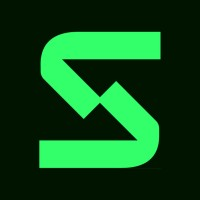
</p>